<a href="https://colab.research.google.com/github/olakoja/DA-MUS/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%B5%D0%B4%D0%BF%D0%BE%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B2%D0%B5%D1%80%D0%BE%D1%8F%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9_%D0%B2%D1%81%D0%B5%D1%85_%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B9_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%2C_%D0%B0_%D0%BD%D0%B5_%D1%82%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE_non_place_%D0%B8_other.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import warnings

# Настройка исходных параметров

In [2]:
# Загрузка данных
polygons = gpd.read_file("/content/1POLYGONS.gpkg")

# Указываем стоюцы, которые считаем лишними для обработки
excess_column = ['osm_way_id', 'osm_changese', 'osm_version', 'osm_uid', 'osm_user',
                'osm_id', 'name', 'layer', 'other_tags', 'path', 'type', 'osm_timestamp',
                'osm_changeset', 'neighbor_boundary_length_None', 'neighbor_ratio_None',
                'building:levels', 'osm_version', 'point_count', 'ref', 'height', 'leaf_type',
                 'description', 'start_date', 'url', 'Санкт-Петербург)', 'area', 'boundary_length',
                 'operator', 'brand'
                 ]
values = [
    'name:', 'wikipedia', 'wikidata', 'website', 'neighbor_boundary_length', 'level', 'addr',
    'building:', 'opening_hours', 'roof:', 'name', 'design:', 'contact:', 'note_', 'official_status',
    'image', '_id', 'kpoos_', 'oktmo:', ':00', '_2', '_3', '_4', 'email', 'phone'
]

In [3]:
# Игнорировать все предупреждения
warnings.filterwarnings("ignore")



# polygons.dropna(subset='place', inplace=True)

polygons = polygons[polygons['non-place1'] != 'water']

# 3.4 Удаляем ненужные столбцы
polygons = polygons.iloc[:,:]
try:
  polygons = polygons.drop(columns=excess_column, errors='ignore')
except Exception:
  pass

polygons = polygons.drop(columns=polygons.columns[polygons.columns.str.contains('|'.join(values))])
polygons = polygons.drop(columns=[col for col in polygons.columns if col.isdigit()])

# Объединение всех прочих категорий в other
# polygons['non-place1'] = polygons['non-place1'].replace({'I': 'other', 'II': 'other', 'III': 'other', 'pustoe': 'other', 'water': 'other'})

# polygons = polygons.loc[:, ~polygons.columns.str.contains('shop_within|name:|contact:website')]
# Сохранение целевой переменной

non_place1_column = polygons['non-place1']

# Удаление исходного столбца 'non-place1' перед обработкой
polygon = polygons.drop(columns=['non-place1'])

# Удаляем столбцы, где слишком мало значений
# threshold = 0.04 * len(polygon)
# Удаляем столбцы, где количество ненулевых значений меньше 4%
# polygon = polygon.loc[:, polygon.notnull().sum() > threshold]

if 'area' in polygon.columns:  # Проверяем, есть ли столбец 'area'
    if polygon['area'].dtype == 'object':  # Проверяем, является ли столбец текстовым
        polygon['area'] = polygon['area'].astype(float)
else:
    print("Столбец 'area' не найден в DataFrame.")

# Укажите название столбца, который нужно обработать
column_name = 'road'

# Получаем уникальные значения из указанного столбца
unique_values = polygon[column_name].unique()

# Фильтруем уникальные значения, которые содержат запятые
values_with_commas = [value for value in unique_values if isinstance(value, str) and ',' in value]

# Создаем новый список уникальных значений, разделяя по запятой
new_unique_values = set()
for value in values_with_commas:
    split_values = value.split(',')
    new_unique_values.update([v.strip() for v in split_values])

# Создаем новые бинарные столбцы для каждого уникального значения
for unique_value in new_unique_values:
    new_column_name = f"{column_name}={unique_value}"
    polygons[new_column_name] = polygons[column_name].apply(
        lambda x: 1 if unique_value in str(x) else 0
    )

# 3.2 Удаляем столбец 'road'
new_data = polygon.drop(columns=['road'], errors='ignore')

# 3.3 Выбираем все текстовые столбцы
text_columns = new_data.select_dtypes(include=['object']).columns.tolist()

# Шаг 7: Создание новых столбцов для каждого уникального значения в текстовых столбцах
for column in text_columns:
    # Получение уникальных значений
    unique_values = new_data[column].unique()

    # Создание новых столбцов для каждого уникального значения
    for value in unique_values:
        new_column_name = f"{column}={value}"
        new_data[new_column_name] = (new_data[column] == value).astype(int)

# 3.6 Удаляем текстовые столбцы после создания бинарных столбцов
new_data = new_data.drop(columns=text_columns, errors='ignore')
substring = "=None"  # Замените на нужную комбинацию символов
new_data = new_data.drop(columns=[col for col in new_data.columns if substring in col])

# Удаление пустых столбцов
df = new_data.dropna(axis=1, how='all')

# Удаление всех текстовых столбцов (оставляем только числовые)
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df_numeric = df[numeric_columns + ['geometry']]
# Добавляем целевую переменную обратно
df_numeric.loc[:, 'non-place1'] = non_place1_column  # Используем .loc для избежания предупреждения
# =========================
# 2. ОБРАБОТКА NULL И NaN
# =========================

# Заменяем NULL на NaN
df_numeric = df_numeric.replace({None: np.nan})

# Удаляем строки, где целевая переменная равна NULL или NaN
gdfd = df_numeric[df_numeric['non-place1'].notna() & (df_numeric['non-place1'] != 'NULL')]

# Создаем GeoDataFrame с отсутствующими значениями в целевой переменной
gdffff = df_numeric[df_numeric['non-place1'].isna() | (df_numeric['non-place1'] == 'NULL')]

#Удаляем строки, где целевая переменная равна NULL или NaN
gdfd = df_numeric[df_numeric['non-place1'].notna() & (df_numeric['non-place1'] != 'NULL')]
# Убедитесь, что целевая переменная является категориальной
polygons['non-place1'] = polygons['non-place1'].astype('category')
# Разделяем данные на признаки (X) и целевую переменную (y)
X = gdfd.drop(columns=['non-place1'])  # Только числовые столбцы
y = gdfd['non-place1']  # Целевая переменная
# Удаляем строки с пропусками в признаках
X = X.fillna(0.0)
y = y[X.index]  # Убедитесь, что y соответствует оставшимся X
# Разделение на обучающую и тестовую выборки

Столбец 'area' не найден в DataFrame.


In [4]:
# Предполагается, что gdfd уже определен и содержит необходимые данные
geometry = gdfd.geometry  # Сохраняем геометрию
X = gdfd.drop(columns=['geometry', 'non-place1'])  # Убираем геометрию и целевую переменную
y = gdfd['non-place1']
# 2. Разделение данных (с сохранением индексов для геометрии)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)
train_geometry = geometry.loc[X_train.index]  # Геометрия для train
test_geometry = geometry.loc[X_test.index]   # Геометрия для test
# Заполнение NaN значений
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)  # Заполнение NaN в тестовом наборе

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)  # Заполнение NaN в тестовом наборе
# Проверка размера обучающего набора
print("Размер обучающего набора:", X_train.shape[0])
print("Распределение классов в y_train:\n", y_train.value_counts())
# 4. Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced'))  # Учитываем стоимость ошибок
])
# 5. Параметры для RandomizedSearch
param_distributions = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'sag', 'saga']
}
# 6. Запуск RandomizedSearchCV с стратифицированной кросс-валидацией
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,  # Проверит только 5 случайных комбинаций
    cv=2,
    n_jobs=-1,
    random_state=42  # Установите random_state для воспроизводимости
)
random_search.fit(X_train, y_train)

# 7. Восстановление GeoDataFrame с результатами
best_model = random_search.best_estimator_
# Убедитесь, что y_test соответствует X_test
y_test = y_test.loc[X_test.index]
# Предсказание
y_pred = best_model.predict(X_test)


Размер обучающего набора: 1270
Распределение классов в y_train:
 non-place1
II           327
I            310
III          270
non-place    236
pustoe       127
Name: count, dtype: int64


Средняя точность модели: 0.5189


Text(0.5, 36.72222222222221, 'Predicted')

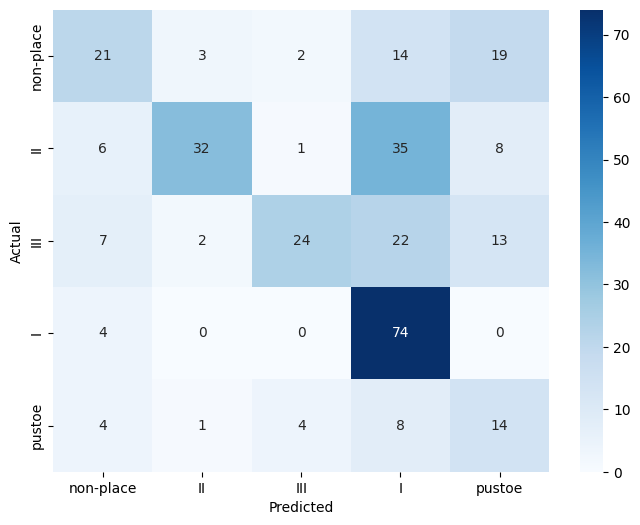

In [5]:
# Предполагается, что y_test и y_pred уже определены
# Пример: y_test = [0, 1, 0, 1], y_pred = [0, 0, 1, 1]
# Убедитесь, что y_test и y_pred являются одномерными массивами
y_test = np.array(y_test)
y_pred = np.array(y_pred)
# Получение общих классов
common_classes = list(set(y_test).intersection(set(y_pred)))
# Вычисление средней точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Средняя точность модели: {accuracy:.4f}")
# Генерация матрицы путаницы
cm = confusion_matrix(y_test, y_pred, labels=common_classes)
# Визуализация матрицы путаницы
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=common_classes, yticklabels=common_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')


Средняя точность модели: 0.5189
Классы в y_test: {'non-place', 'II', 'III', 'I', 'pustoe'}
Классы в y_pred: {'non-place', 'II', 'III', 'I', 'pustoe'}

=== Отчет о классификации ===
              precision    recall  f1-score   support

           I       0.48      0.95      0.64        78
          II       0.84      0.39      0.53        82
         III       0.77      0.35      0.48        68
   non-place       0.50      0.36      0.42        59
      pustoe       0.26      0.45      0.33        31

    accuracy                           0.52       318
   macro avg       0.57      0.50      0.48       318
weighted avg       0.62      0.52      0.51       318



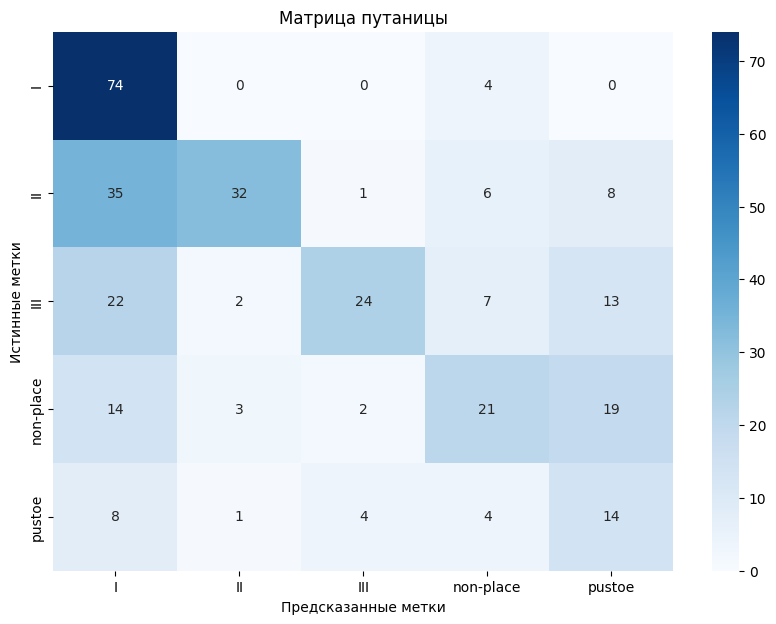

In [6]:
# Вычисление средней точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Средняя точность модели: {accuracy:.4f}")
# Получение отчета о классификации
print("Классы в y_test:", set(y_test))
print("Классы в y_pred:", set(y_pred))
report = classification_report(y_test, y_pred, target_names=sorted(set(y_test)), zero_division=0)
print("\n=== Отчет о классификации ===")
print(report)
# Получение матрицы путаницы
conf_matrix = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
# Визуализация матрицы путаницы
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title('Матрица путаницы')
plt.show()

In [7]:
best_pipeline = random_search.best_estimator_
model = best_pipeline.named_steps['classifier']
if hasattr(model, 'coef_'):
    coefs = model.coef_
    classes = model.classes_
    # Если бинарная классификация с shape (1, n_features), дублируем для удобства
    if coefs.shape[0] == 1 and len(classes) == 2:
        coefs = np.vstack([-coefs, coefs])
    for class_idx, class_name in enumerate(classes):
        coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefs[class_idx]})
        coef_df = coef_df.assign(Abs_Coefficient=coef_df['Coefficient'].abs())\
                         .sort_values('Abs_Coefficient', ascending=False)
        print(f"\n--- Топ-20 признаков для класса '{class_name}' ---")
        display(coef_df[['Feature', 'Coefficient']].head(20))
else:
    print("Модель не имеет коэффициентов")


--- Топ-20 признаков для класса 'I' ---


,Feature,Coefficient
642,building=apartments,0.410189
855,non-place=I_place,0.289888
498,ball,0.195997
567,leisure=park,-0.192617
802,residential=urban,0.178362
705,landuse=residential,0.178362
706,landuse=grass,-0.167411
853,non-place=service,-0.164139
786,place=square,-0.106954
508,food_within_10m_restaurant,0.086703



--- Топ-20 признаков для класса 'II' ---


,Feature,Coefficient
640,building=yes,0.326133
706,landuse=grass,-0.231332
852,non-place=II_place,0.228595
498,ball,0.190899
567,leisure=park,-0.175272
786,place=square,-0.155159
684,historic=heritage,-0.130816
843,operator:type=public,0.120771
703,landuse=industrial,0.107123
754,amenity=kindergarten,0.104705



--- Топ-20 признаков для класса 'III' ---


,Feature,Coefficient
567,leisure=park,0.181308
856,non-place=III_place,0.159781
640,building=yes,-0.155823
642,building=apartments,-0.136209
498,ball,0.116486
566,leisure=playground,0.106242
786,place=square,0.093630
852,non-place=II_place,-0.093383
506,food_within_50m_pub,-0.088802
706,landuse=grass,0.087269



--- Топ-20 признаков для класса 'non-place' ---


,Feature,Coefficient
498,ball,-0.293705
10,bench_distance,0.138567
503,food_within_50m_cafe,0.126818
502,food_within_10m_cafe,0.120371
786,place=square,0.102730
708,landuse=retail,-0.095997
504,food_within_100m_cafe,0.092891
507,food_within_100m_pub,0.087970
508,food_within_10m_restaurant,0.086429
591,man_made=bridge,0.084410



--- Топ-20 признаков для класса 'pustoe' ---


,Feature,Coefficient
706,landuse=grass,0.228749
498,ball,-0.209677
802,residential=urban,-0.198355
705,landuse=residential,-0.198355
567,leisure=park,0.170112
855,non-place=I_place,-0.167513
704,landuse=commercial,0.150424
853,non-place=service,0.145294
643,building=industrial,0.116034
707,landuse=garages,0.112957


In [8]:
# Вывод значимых признаков
coef_df[['Feature', 'Coefficient']].iloc[41:80]

,Feature,Coefficient
732,parking=surface,-0.031620
566,leisure=playground,-0.031573
499,food_within_10m_fast_food,-0.029714
505,food_within_10m_pub,-0.028822
657,building=kindergarten,-0.028491
754,amenity=kindergarten,-0.028116
810,power=substation,-0.027428
591,man_made=bridge,-0.027248
652,building=office,-0.026666
709,landuse=construction,-0.026657


In [9]:
# Вывод значимых признаков
coef_df[['Feature', 'Coefficient']].iloc[81:140]

,Feature,Coefficient
813,fee=yes,-0.009844
501,food_within_100m_fast_food,-0.009764
580,access=private,0.009742
663,building=civic,-0.009384
778,amenity=public_building,-0.009384
507,food_within_100m_pub,0.008892
746,shop=car_repair,-0.008526
826,natural=wetland,-0.008340
857,non-place=pusytoe,-0.008340
677,barrier=fence,-0.008086


In [10]:
# 1. Подготовка данных для всех объектов (без целевой переменной и столбцов с предсказаниями)
features_for_prediction = df_numeric.drop(columns=[
    col for col in df_numeric.columns
    if col in ['non-place1', 'geometry'] or col.endswith('.predikt')
]).fillna(0)

# 2. Получаем предсказания только для нужных признаков
all_probabilities = best_model.predict_proba(features_for_prediction)

# 3. Создаем DataFrame с вероятностями для всех объектов
all_prob_df = pd.DataFrame(
    all_probabilities,
    columns=[f"{value}.predikt" for value in best_model.classes_],
    index=features_for_prediction.index
)

# 4. Удаляем старые предсказания если они есть
existing_pred_cols = [col for col in df_numeric.columns if col.endswith('.predikt')]
if existing_pred_cols:
    df_numeric = df_numeric.drop(columns=existing_pred_cols)

# 5. Добавляем новые предсказания
df_numeric = df_numeric.join(all_prob_df)

# 6. Сохраняем результаты (как GeoDataFrame)
gdf_result = gpd.GeoDataFrame(
    df_numeric.drop(columns=['geometry']),
    geometry=df_numeric['geometry'],
    crs=polygons.crs
)
gdf_result.to_file("All_Predictions.gpkg", driver="GPKG")

print(f"Предсказания добавлены для {len(df_numeric)} объектов")
print("Столбцы с предсказаниями:", list(all_prob_df.columns))

Предсказания добавлены для 6827 объектов
Столбцы с предсказаниями: ['I.predikt', 'II.predikt', 'III.predikt', 'non-place.predikt', 'pustoe.predikt']


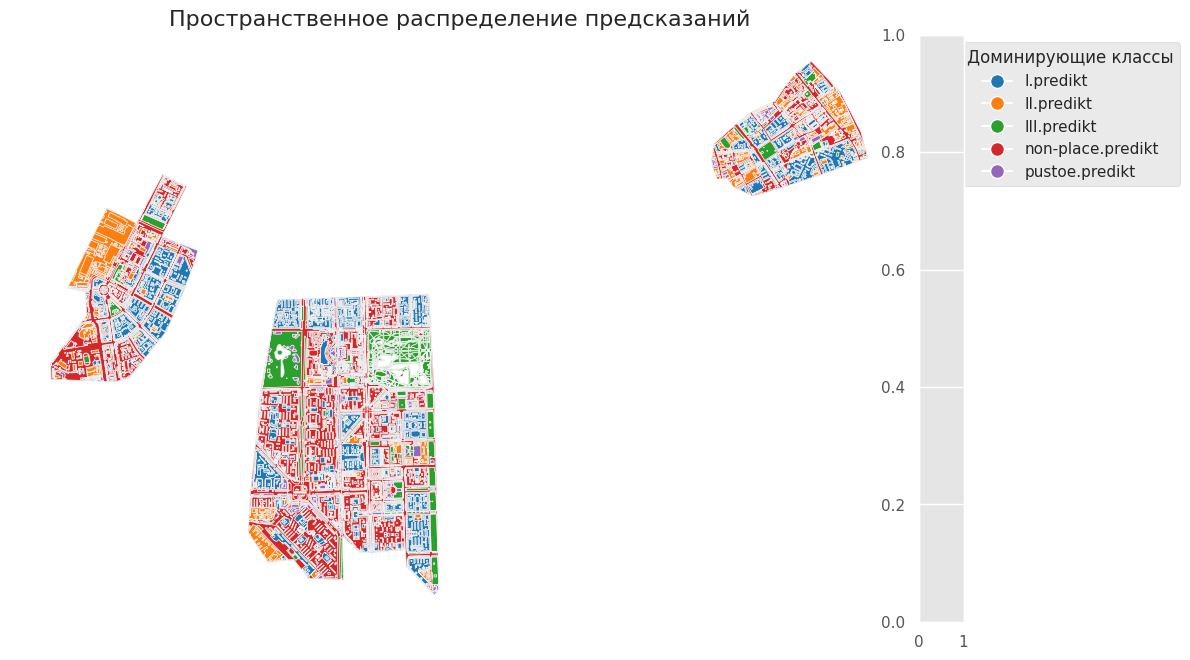

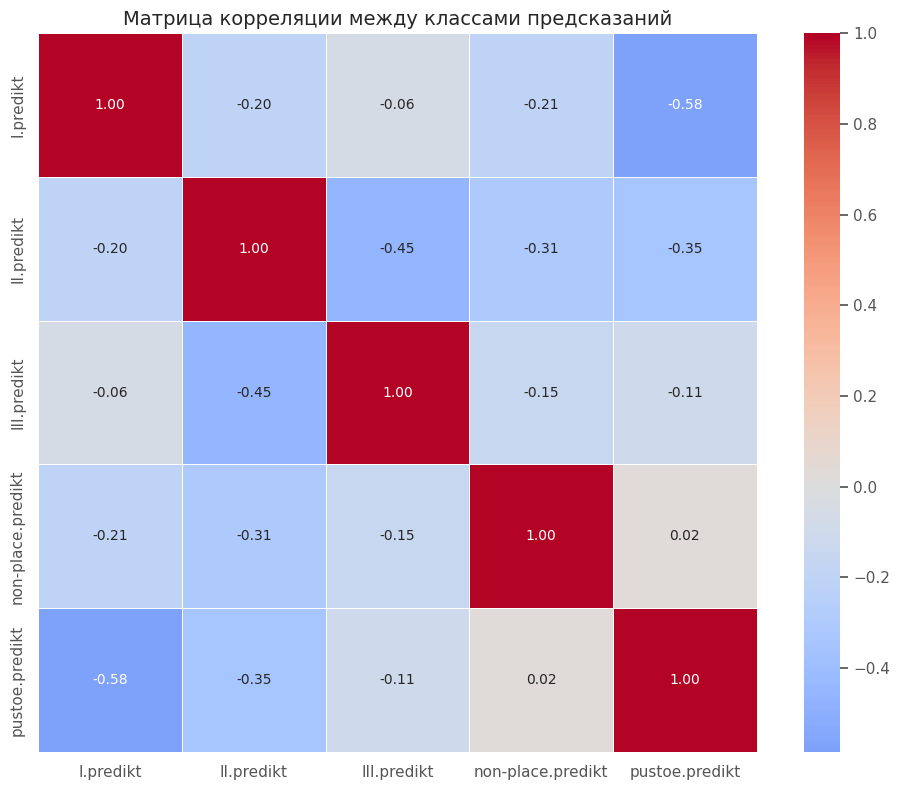

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from matplotlib.lines import Line2D  # Импортируем Line2D

# Установка красивого стиля
sns.set(style="whitegrid")
plt.style.use('ggplot')


# Задаем названия столбцов с предсказаниями
prediction_cols = ['I.predikt', 'II.predikt', 'III.predikt', 'non-place.predikt', 'pustoe.predikt']
# 1. Создание столбца с доминирующим классом
gdf_result['dominant_class'] = gdf_result[prediction_cols].idxmax(axis=1)
# 2. Пространственная визуализация
fig, ax = plt.subplots(figsize=(12, 10))
# Цветовая схема для классов
class_colors = {
    'I.predikt': '#1f77b4',
    'II.predikt': '#ff7f0e',
    'III.predikt': '#2ca02c',
    'non-place.predikt': '#d62728',
    'pustoe.predikt': '#9467bd'
}
# Визуализируем полигоны с цветами по доминирующему классу
for cls, color in class_colors.items():
    gdf_result[gdf_result['dominant_class'] == cls].plot(ax=ax, color=color)
# Настройки отображения
ax.set_title('Пространственное распределение предсказаний', fontsize=16)
# Создаем легенду с правильными цветами
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cls,
                           markerfacecolor=color, markersize=10) for cls, color in class_colors.items()]
ax.legend(handles=legend_elements, title='Доминирующие классы', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axis_off()
# Добавляем шкалу
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.tight_layout()
plt.show()
# 3. Матрица корреляции предсказаний
plt.figure(figsize=(10, 8))
corr_matrix = gdf_result[prediction_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=.5, square=True)
plt.title('Матрица корреляции между классами предсказаний', fontsize=14)
plt.tight_layout()
plt.show()